In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, LSTM, Embedding
from tensorflow.keras.models import Model


In [3]:
# Downloading data  -  this URL isn't working directly with pd.read_csv

!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2020-06-18 08:37:28--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 172.67.213.166, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.01s   

2020-06-18 08:37:29 (35.4 MB/s) - ‘spam.csv’ saved [503663/503663]



In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Dropping unnecessary columns

df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Renaming the columns

df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Creating binary labels

df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})
Y = df['b_labels'].values

In [8]:
# Splitting the data
# this function can accepts dataframe as input and return dataframe

df_train, df_test, Y_train, Y_test = train_test_split(df['data'], Y, test_size=0.33)

In [9]:
# Converting sentences to sequences

MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [10]:
# Word toindex mapping

word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s uniue tokens.' % V)

Found 7309 uniue tokens.


In [12]:
# Padding seuences - we get N x T matrix
# We take max size of train as T so that if any larger length encounters in sequences_test it'll be truncated.

data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [13]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [14]:
# Creating model

# Embedding dimentionality - (Hyperparameter)
D = 20

# Hidden state dimentionality - (Hyperparameter)
M = 15

i = Input(shape=(T,))
x = Embedding(V+1, D)(i) # counts from 1 as tensorflow uses  for paddings
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)


In [15]:
# Compiling and Training the model

print('Compiling the model...')
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Training the model...')
r = model.fit(data_train, Y_train,
              epochs=10,
              validation_data=(data_test, Y_test))

Compiling the model...
Training the model...
Epoch 1/10
117/117 [==============================] - 5s 40ms/step - loss: 0.4785 - accuracy: 0.8508 - val_loss: 0.3630 - val_accuracy: 0.8782
Epoch 2/10
117/117 [==============================] - 4s 36ms/step - loss: 0.3519 - accuracy: 0.8599 - val_loss: 0.2540 - val_accuracy: 0.8782
Epoch 3/10
117/117 [==============================] - 4s 37ms/step - loss: 0.1888 - accuracy: 0.9170 - val_loss: 0.1493 - val_accuracy: 0.9685
Epoch 4/10
117/117 [==============================] - 4s 36ms/step - loss: 0.1033 - accuracy: 0.9855 - val_loss: 0.1153 - val_accuracy: 0.9744
Epoch 5/10
117/117 [==============================] - 4s 36ms/step - loss: 0.0644 - accuracy: 0.9920 - val_loss: 0.0983 - val_accuracy: 0.9750
Epoch 6/10
117/117 [==============================] - 4s 36ms/step - loss: 0.0459 - accuracy: 0.9949 - val_loss: 0.0907 - val_accuracy: 0.9755
Epoch 7/10
117/117 [==============================] - 4s 36ms/step - loss: 0.0355 - accuracy: 0.9

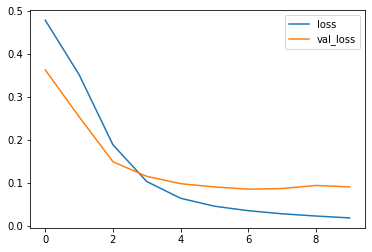

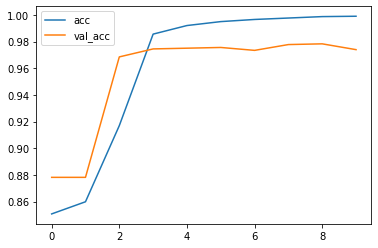

In [16]:
# Plotting loss per iteration

plt.figure(1)
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

# Plotting accuracy per iteration

plt.figure(2)
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()